# Mounting Google Drive and Loading Data


In [0]:
# Stop from disconnecting

'''
function ClickConnect(){
  console.log("Connnect Clicked - Start"); 
  document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
  console.log("Connnect Clicked - End"); 
};
setInterval(ClickConnect, 60000)
'''

'\nfunction ClickConnect(){\n  console.log("Connnect Clicked - Start"); \n  document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();\n  console.log("Connnect Clicked - End"); \n};\nsetInterval(ClickConnect, 60000)\n'

In [0]:
!nvidia-smi

Mon Mar 23 03:14:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

!unzip -q -o "/content/gdrive/My Drive/college/CS491-DL/Project1/data/Small_set_cats_vs_dogs.zip"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# #Generate root password
# import random, string
# password = ''.join(random.choice(string.ascii_letters + string.digits) for i in range(20))

# #Download ngrok
# ! wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# ! unzip -qq -n ngrok-stable-linux-amd64.zip
# #Setup sshd
# ! apt-get install -qq -o=Dpkg::Use-Pty=0 openssh-server pwgen > /dev/null
# #Set root password
# ! echo root:$password | chpasswd
# ! mkdir -p /var/run/sshd
# ! echo "PermitRootLogin yes" >> /etc/ssh/sshd_config
# ! echo "PasswordAuthentication yes" >> /etc/ssh/sshd_config
# ! echo "LD_LIBRARY_PATH=/usr/lib64-nvidia" >> /root/.bashrc
# ! echo "export LD_LIBRARY_PATH" >> /root/.bashrc

# #Run sshd
# get_ipython().system_raw('/usr/sbin/sshd -D &')

# #Ask token
# print("Copy authtoken from https://dashboard.ngrok.com/auth")
# import getpass
# authtoken = getpass.getpass()

# #Create tunnel
# get_ipython().system_raw('./ngrok authtoken $authtoken && ./ngrok tcp 22 &')
# #Print root password
# print("Root password: {}".format(password))
# #Get public address
# ! curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

# Importing Necessary Libraries

In [0]:
import tensorflow as tf
import tensorflow.keras 

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D 
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense 
from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.applications.resnet50 import ResNet50 
import numpy as np 
from tensorflow.keras.preprocessing import image 

import matplotlib.pyplot as plt 
%matplotlib inline 

# Hyper-Parameters Initialization

In [0]:
epochs = 90
batch_size = 100
training_samples = 4000
validation_samples = 600
img_width = 224
img_height = 224
channels = 3
input_shape = (img_width,img_height,channels)

# Data Generator

In [0]:
train_data_dir = 'Small_set_cats_vs_dogs/train'
validation_data_dir = 'Small_set_cats_vs_dogs/val'

train_datagen = ImageDataGenerator( 
    rescale=1. / 255,
    shear_range=0.1, 
    zoom_range=0.2, 
    rotation_range=20,
	width_shift_range=0.2,
	height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
    )

# Validation Data
val_datagen = ImageDataGenerator(rescale=1. / 255) 

In [0]:
# Original Data
train_generator = train_datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size
    )

# Validation Data
validation_generator = val_datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size
    ) 

Found 4000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


# Image Augmentation

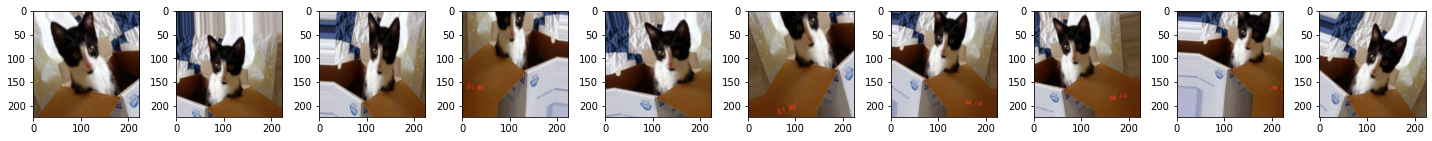

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()    
  
augmented_images = [train_generator[0][0][0] for i in range(10)]
plotImages(augmented_images)

# CNN Model

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape, padding='same', activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2))) 

model.add(Conv2D(64, (3, 3), padding='same', activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2))) 

model.add(Conv2D(128, (3, 3), padding='same', activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2))) 

model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2))) 

model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2))) 

model.add(Flatten()) 
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# VGG16 and VGG19 below ======================================================================

# model = Sequential()
# model.add(Conv2D(64, (3, 3), input_shape=input_shape, padding='same', activation='relu')) 
# model.add(Conv2D(64, (3, 3), padding='same', activation='relu')) 
# model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2))) 

# model.add(Conv2D(128, (3, 3), padding='same', activation='relu')) 
# model.add(Conv2D(128, (3, 3), padding='same', activation='relu')) 
# model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2))) 

# model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) 
# model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) 
# model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) 
# # model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) 
# model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2))) 

# model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) 
# model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) 
# model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) 
# # model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) 
# model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2))) 

# model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) 
# model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) 
# model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) 
# # model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) 
# model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2))) 

# model.add(Flatten()) 
# model.add(Dense(4096, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(4096, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(2, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy']) 

# Model Layout and Visualization




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2

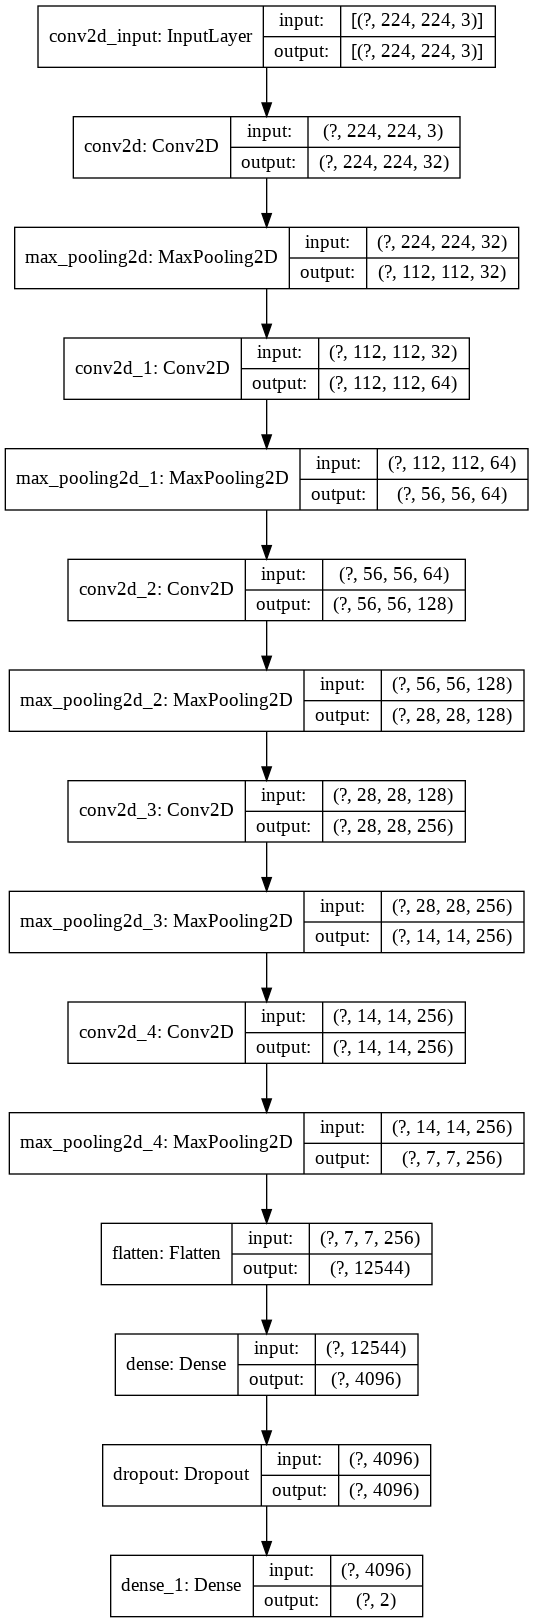

In [0]:
model.summary()
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Callbacks [Bonus]


In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=.5, patience=7, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

snapshot_name = 'dummy_model_'
checkpoint = ModelCheckpoint(filepath=snapshot_name+".{epoch:02d}-{val_acc:.2f}.hdf5", monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')

# Training and Validation

In [0]:
# Training on data
history = model.fit_generator(train_generator, 
    steps_per_epoch = training_samples // batch_size, 
    epochs = epochs, validation_data = validation_generator, 
    validation_steps = validation_samples // batch_size,
    callbacks = [reduce_lr]
    ) 

Epoch 1/90
40/40 [==============================] - 50s 1s/step - loss: 1.3085 - acc: 0.5107 - val_loss: 0.6922 - val_acc: 0.5000
Epoch 2/90
40/40 [==============================] - 53s 1s/step - loss: 0.6907 - acc: 0.5458 - val_loss: 0.7138 - val_acc: 0.5267
Epoch 3/90
40/40 [==============================] - 53s 1s/step - loss: 0.7046 - acc: 0.5263 - val_loss: 0.7378 - val_acc: 0.5000
Epoch 4/90
40/40 [==============================] - 53s 1s/step - loss: 0.6954 - acc: 0.5410 - val_loss: 0.7210 - val_acc: 0.5133
Epoch 5/90
40/40 [==============================] - 53s 1s/step - loss: 0.6980 - acc: 0.5567 - val_loss: 0.6815 - val_acc: 0.5583
Epoch 6/90
40/40 [==============================] - 53s 1s/step - loss: 0.6795 - acc: 0.5775 - val_loss: 0.6448 - val_acc: 0.6283
Epoch 7/90
40/40 [==============================] - 53s 1s/step - loss: 0.6942 - acc: 0.5930 - val_loss: 0.6321 - val_acc: 0.6717
Epoch 8/90
40/40 [==============================] - 53s 1s/step - loss: 0.6530 - acc: 0.63

In [0]:
model.save_weights('model_saved.h5') 

# Evaluating the test data

In [0]:
test_data_dir = 'Small_set_cats_vs_dogs/test'

test_datagen = ImageDataGenerator(rescale=1. / 255) 

test_generator = test_datagen.flow_from_directory( 
    test_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size
    ) 

Found 200 images belonging to 2 classes.


In [0]:
model.evaluate_generator(test_generator, verbose=2)

2/2 - 1s - loss: 0.2681 - acc: 0.9250


[0.2680586278438568, 0.925]

# Plotting Accuracy and Loss Graph

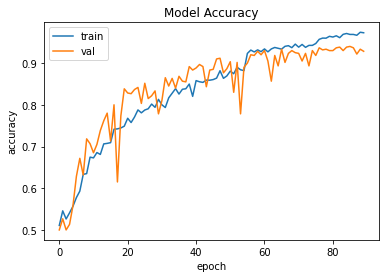

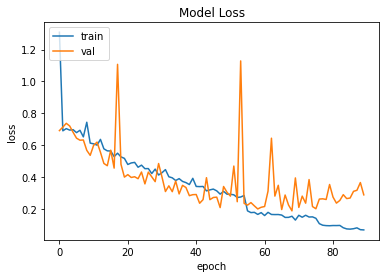

In [0]:
# Ploting on data
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Acc.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Loss.png')
plt.show()

In [0]:
!cp *.png "gdrive/My Drive/college/CS491-DL/Project3/data/"

# Predicting some sample images

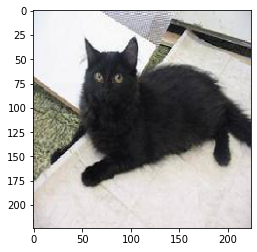

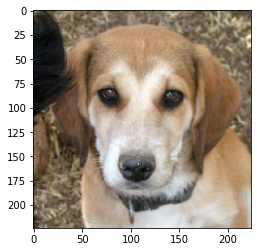

In [0]:
img = image.load_img('/content/Small_set_cats_vs_dogs/test/cat/cat.6059.jpg', target_size=(img_width, img_height))
img_2 = image.load_img('/content/Small_set_cats_vs_dogs/test/dog/dog.5026.jpg', target_size=(img_width, img_height))
plt.imshow(img)
plt.show()
plt.imshow(img_2)
plt.show()

In [0]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
y = image.img_to_array(img_2)
y = np.expand_dims(y, axis=0)
images = np.vstack([x,y])

In [0]:
# Results from data

# Prediction result
pred = model.predict(images)
print (pred)
print()

# Class Prediction
pred_class = model.predict_classes(images)
print (pred_class)

[[1. 0.]
 [0. 1.]]

[0 1]
